<h1>CIFAR 10</h1>

<h1>Importing Modules</h1>


In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Loading Data

In [15]:
train_batchsize = 10
test_batchsize = 10
resized_img_size = 32
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize(size=(resized_img_size, resized_img_size)),
     torchvision.transforms.ToTensor()])
train_data = torchvision.datasets.CIFAR10(root='data', train=True,
                                        download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='data', train=False,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_batchsize)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=test_batchsize)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Visualize data

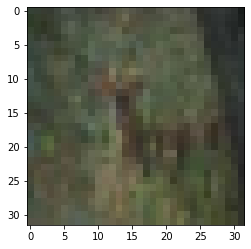

In [16]:
plt.imshow(train_data[10][0].permute(1,2,0)) 

# Model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = 
    def forward(self,x):
        return x